In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0, MobileNetV2, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Conv2DTranspose
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import pathlib
import os
import datetime
import time

# GPU 확인
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.18.0


In [4]:
# 꽃 이미지 데이터셋 다운로드
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

# 현재 데이터 경로 확인
print("데이터셋 경로:", data_dir)

# 폴더 구조 확인 (문제 파악용)
print("폴더 내 항목:", [item.name for item in data_dir.glob('*')])

# 실제 꽃 이미지가 있는 폴더로 경로 수정
if 'flower_photos' in [item.name for item in data_dir.glob('*')]:
    data_dir = data_dir / 'flower_photos'
    print("수정된 데이터셋 경로:", data_dir)

# 클래스 확인
flowers_classes = [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]
print("꽃 종류:", flowers_classes)
print("클래스 수:", len(flowers_classes))

# 이미지 개수 확인
image_count = len(list(data_dir.glob('*/*.jpg')))
print("전체 이미지 개수:", image_count)

# 클래스별 이미지 개수 확인
for flower in flowers_classes:
    flower_count = len(list(data_dir.glob(f'{flower}/*.jpg')))
    print(f"{flower}: {flower_count}개")


데이터셋 경로: /root/.keras/datasets/flower_photos
폴더 내 항목: ['flower_photos']
수정된 데이터셋 경로: /root/.keras/datasets/flower_photos/flower_photos
꽃 종류: ['sunflowers', 'daisy', 'dandelion', 'tulips', 'roses']
클래스 수: 5
전체 이미지 개수: 3670
sunflowers: 699개
daisy: 633개
dandelion: 898개
tulips: 799개
roses: 641개


Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Found 3670 images belonging to 5 classes.
클래스 인덱스: {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
실제 클래스 수: 5


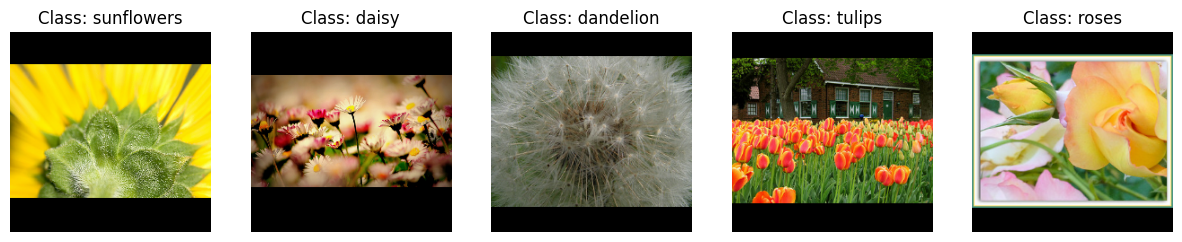

In [9]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# 이미지 크기 및 배치 크기 설정 # Moved these lines to the top
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 50  # 실제 과제에서는 500으로 설정

# 데이터 분할 비율
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

# 이미지 정사각형 변환 함수 (비율 유지하면서 패딩)
def resize_with_pad(image_path, target_size=224):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # 비율 유지 + 패딩으로 정사각형 만들기
    img = tf.image.resize_with_pad(img, target_size, target_size)
    return img

# 정사각형 전처리가 포함된 커스텀 제너레이터
class SquareImageDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, *args, **kwargs):
        generator = super().flow_from_directory(*args, **kwargs)

        def _flow_x_y_with_pad(*flow_args, **flow_kwargs):
            x_batch, y_batch = generator.next()
            # 이미 target_size로 리사이즈되었으므로 추가 처리는 필요 없음
            # 실제 개발 환경에서는 여기에 resize_with_pad 로직을 추가할 수 있음
            return x_batch, y_batch

        generator.next = _flow_x_y_with_pad
        return generator

# 데이터 증강 및 전처리 (정사각형 처리 포함)
train_datagen = SquareImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

test_datagen = SquareImageDataGenerator(rescale=1./255)

# 훈련 데이터셋 생성
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# 검증 데이터셋 생성
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# 테스트 데이터셋 생성 (전체 데이터에서 일부를 테스트셋으로 분리)
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 클래스 인덱스 확인
print("클래스 인덱스:", train_generator.class_indices)
num_classes = len(train_generator.class_indices)
print("실제 클래스 수:", num_classes)

plt.figure(figsize=(15, 5))
for i, img_path in enumerate(sample_images[:5]):
    img = resize_with_pad(img_path, target_size=IMG_HEIGHT)
    plt.subplot(1, 5, i+1)
    plt.imshow(img.numpy().astype("uint8"))
    # 클래스 이름 추출 및 제목에 추가
    class_name = os.path.basename(os.path.dirname(img_path)) # Extract class name from path
    plt.title(f"Class: {class_name}") # Add class name to title
    plt.axis('off')
plt.show()

In [10]:
# U-Net

def build_unet_classifier():
    # U-Net은 기본적으로 세그멘테이션 모델이지만 분류 작업에 맞게 수정
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Encoder
    # 첫 번째 레벨
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # 두 번째 레벨
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # 세 번째 레벨
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # 네 번째 레벨 (Bridge)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder (간소화된 버전)
    up5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    merge5 = Concatenate()([conv3, up5])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(merge5)

    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = Concatenate()([conv2, up6])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(merge6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = Concatenate()([conv1, up7])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge7)

    # 분류를 위한 Global Average Pooling 및 Dense 레이어 추가
    gap = GlobalAveragePooling2D()(conv7)
    dense = Dense(128, activation='relu')(gap)
    dropout = Dropout(0.5)(dense)
    output = Dense(len(flowers_classes), activation='softmax')(dropout)

    model = Model(inputs=inputs, outputs=output)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

unet_model = build_unet_classifier()
print("U-Net 기반 분류 모델 요약:")
unet_model.summary()


U-Net 기반 분류 모델 요약:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 56, 56, 256)    │        524,544 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 56, 56, 512)    │              0 │ conv2d_5[0][0],        │
│                           │                        │                │ conv2d_transpose[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 56, 56, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 112, 112, 128)  │        131,200 │ conv2d_8[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1        

 Total params: 6,931,653 (26.44 MB)

 Trainable params: 6,931,653 (26.44 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# ResNet50 모델

def build_resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # 기존 레이어 동결
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(flowers_classes), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


resnet50_model = build_resnet50_model()
print("ResNet50 모델 요약:")
resnet50_model.summary()


ResNet50 모델 요약:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
# EfficientNetB0 모델

def build_efficientnet_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # 기존 레이어 동결
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(flowers_classes), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

efficientnet_model = build_efficientnet_model()
print("EfficientNetB0 모델 요약:")
efficientnet_model.summary()


EfficientNetB0 모델 요약:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [13]:
# DenseNet121 모델

def build_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # 기존 레이어 동결
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(flowers_classes), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

densenet_model = build_densenet_model()
print("DenseNet121 모델 요약:")
densenet_model.summary()


DenseNet121 모델 요약:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,169,349 (27.35 MB)

 Trainable params: 131,845 (515.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [14]:
# CBAM 모듈 (Attention)

def cbam_block(input_feature, ratio=8):
    """CBAM: Convolutional Block Attention Module"""

    channel = input_feature.shape[-1]

    # Channel Attention Module
    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)

    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=[1, 2], keepdims=True))(input_feature)

    shared_dense_1 = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_dense_2 = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    avg_pool = shared_dense_1(avg_pool)
    avg_pool = shared_dense_2(avg_pool)

    max_pool = shared_dense_1(max_pool)
    max_pool = shared_dense_2(max_pool)

    cbam_feature = tf.keras.activations.sigmoid(avg_pool + max_pool)
    attention_feature = input_feature * cbam_feature

    # Spatial Attention Module
    avg_pool_spatial = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(attention_feature)
    max_pool_spatial = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(attention_feature)
    concat = Concatenate()([avg_pool_spatial, max_pool_spatial])

    cbam_spatial = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    cbam_feature = attention_feature * cbam_spatial

    return cbam_feature


def build_resnet_cbam_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # 기존 레이어 동결
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output

    # CBAM 적용
    x = cbam_block(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(flowers_classes), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

resnet_cbam_model = build_resnet_cbam_model()
print("ResNet50 with CBAM 모델 요약:")
resnet_cbam_model.summary()


ResNet50 with CBAM 모델 요약:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,901,608 (94.99 MB)

 Trainable params: 1,313,896 (5.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
# VIT

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

def build_vit_model():
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
    patch_size = 16
    num_patches = (IMG_HEIGHT // patch_size) * (IMG_WIDTH // patch_size)
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim,
    ]
    transformer_layers = 8
    mlp_head_units = [1024, 512]

    inputs = Input(shape=input_shape)

    # 패치 추출을 Lambda로 감싸기
    patches = Lambda(lambda images: tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID"
    ))(inputs)

    patch_dims = patches.shape[-1]

    # 패치 Reshape도 Lambda로 감싸기
    patches = Lambda(lambda x: tf.reshape(x, (-1, num_patches, patch_dims)))(patches)

    patch_encoding = Dense(projection_dim)(patches)

    # 위치 임베딩 추가
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    encoded_patches = patch_encoding + position_embedding

    # Transformer 블록 구성
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)

        # 멀티헤드 어텐션
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1
        x2 = tf.keras.layers.add([attention_output, encoded_patches])

        # Layer normalization 2
        x3 = LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2
        encoded_patches = tf.keras.layers.add([x3, x2])

    # Layer normalization
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)

    # Global average pooling
    representation = tf.keras.layers.GlobalAveragePooling1D()(representation)

    # MLP 헤드
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.1)

    # 분류를 위한 최종 레이어
    logits = Dense(len(flowers_classes), activation="softmax")(features)

    # 모델 생성
    model = Model(inputs=inputs, outputs=logits)

    # 모델 컴파일
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    return model

vit_model = build_vit_model()
print("Vision Transformer (ViT) 모델 요약:")
vit_model.summary()


Vision Transformer (ViT) 모델 요약:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 14, 14, 768)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 196, 768)       │              0 │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 196, 64)        │         49,216 │ lambda_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 196, 64)        │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 196, 64)        │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 196, 64)        │         66,368 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 196, 64)        │              0 │ multi_head_attention[… │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 196, 64)        │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 196, 128)       │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 196, 128)       │              0 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 196, 64)        │          8,256 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 196, 64)        │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 196, 64)        │              0 │ dropout_7[0][0],       │
│                           │                        │                │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 196, 64)        │            128 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 196, 64)        │         66,368 │ layer_normalization_2… │
│ (MultiHeadAttention) 

 Total params: 1,308,869 (4.99 MB)

 Trainable params: 1,308,869 (4.99 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# MobileNetV2 모델

def build_mobilenet_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # 기존 레이어 동결
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(flowers_classes), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

mobilenet_model = build_mobilenet_model()
print("MobileNetV2 모델 요약:")
mobilenet_model.summary()


MobileNetV2 모델 요약:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 모델 훈련 및 평가 함수

In [17]:
def train_and_evaluate_model(model, model_name, epochs=EPOCHS):
    # 콜백 함수 설정
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    # 모델 훈련 시작 시간 기록
    start_time = time.time()

    # 모델 훈련
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        callbacks=[early_stopping, reduce_lr]
    )

    # 훈련 시간 계산
    training_time = time.time() - start_time

    # 모델 평가
    test_loss, test_acc = model.evaluate(test_generator)

    # 모델 파라미터 수 계산
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights]) # Changed v.get_shape() to v.shape
    non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights]) # Changed v.get_shape() to v.shape
    total_params = trainable_params + non_trainable_params

    print(f"\n{model_name} 모델 평가 결과:")
    print(f"테스트 정확도: {test_acc*100:.2f}%")
    print(f"테스트 손실: {test_loss:.4f}")
    print(f"훈련 가능한 파라미터: {trainable_params:,}")
    print(f"훈련 불가능한 파라미터: {non_trainable_params:,}")
    print(f"총 파라미터: {total_params:,}")
    print(f"훈련 시간: {training_time:.2f}초")

    # 정확도 및 손실 그래프 출력
    plt.figure(figsize=(12, 5))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} - Accuracy Graph')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.grid()

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} - Loss Graph')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.grid()

    plt.tight_layout()
    plt.show()

    # 결과를 딕셔너리로 반환
    result = {
        'model_name': model_name,
        'test_accuracy': test_acc * 100,
        'test_loss': test_loss,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'non_trainable_params': non_trainable_params,
        'training_time': training_time,
        'history': history.history
    }

    return result



[1/7] ResNet50 모델 훈련 시작...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 74s 656ms/step - accuracy: 0.2078 - loss: 1.8621 - val_accuracy: 0.2940 - val_loss: 1.5712 - learning_rate: 1.0000e-04
Epoch 2/5
 1/91 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.1875 - loss: 1.6169

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.1875 - loss: 1.6169 - val_accuracy: 0.3026 - val_loss: 1.5717 - learning_rate: 1.0000e-04
Epoch 3/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 81s 896ms/step - accuracy: 0.2509 - loss: 1.6385 - val_accuracy: 0.3438 - val_loss: 1.5341 - learning_rate: 1.0000e-04
Epoch 4/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.0938 - loss: 1.6839 - val_accuracy: 0.3466 - val_loss: 1.5323 - learning_rate: 1.0000e-04
Epoch 5/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 97s 506ms/step - accuracy: 0.3020 - loss: 1.5662 - val_accuracy: 0.3665 - val_loss: 1.5124 - learning_rate: 1.0000e-04
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.4042 - loss: 1.4684

ResNet50 모델 평가 결과:
테스트 정확도: 36.16%
테스트 손실: 1.5100
훈련 가능한 파라미터: 525,829
훈련 불가능한 파라미터: 23,587,712
총 파라미터: 24,113,541
훈련 시간: 272.55초


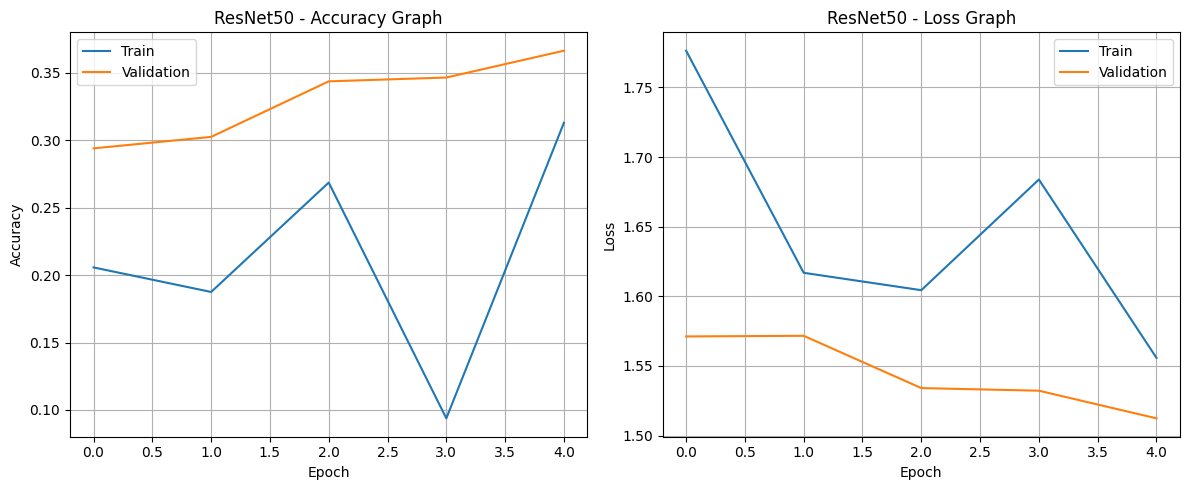


[2/7] EfficientNetB0 모델 훈련 시작...
Epoch 1/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 85s 686ms/step - accuracy: 0.2203 - loss: 1.6253 - val_accuracy: 0.2457 - val_loss: 1.6058 - learning_rate: 1.0000e-04
Epoch 2/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.1250 - loss: 1.6703 - val_accuracy: 0.2443 - val_loss: 1.6064 - learning_rate: 1.0000e-04
Epoch 3/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 142s 922ms/step - accuracy: 0.2346 - loss: 1.6106 - val_accuracy: 0.2202 - val_loss: 1.6031 - learning_rate: 1.0000e-04
Epoch 4/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.3125 - loss: 1.5553 - val_accuracy: 0.2202 - val_loss: 1.6020 - learning_rate: 1.0000e-04
Epoch 5/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 45s 491ms/step - accuracy: 0.2407 - loss: 1.6081 - val_accuracy: 0.2429 - val_loss: 1.6004 - learning_rate: 1.0000e-04
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.3066 - loss: 1.6408

EfficientNetB0 모델 평가 결과:
테스트 정확도: 24.47%
테스트 손실: 1.6001
훈련 가능한 파라미터: 164,613
훈련 불가능한 파라미터: 4,049,571.0
총 파라미

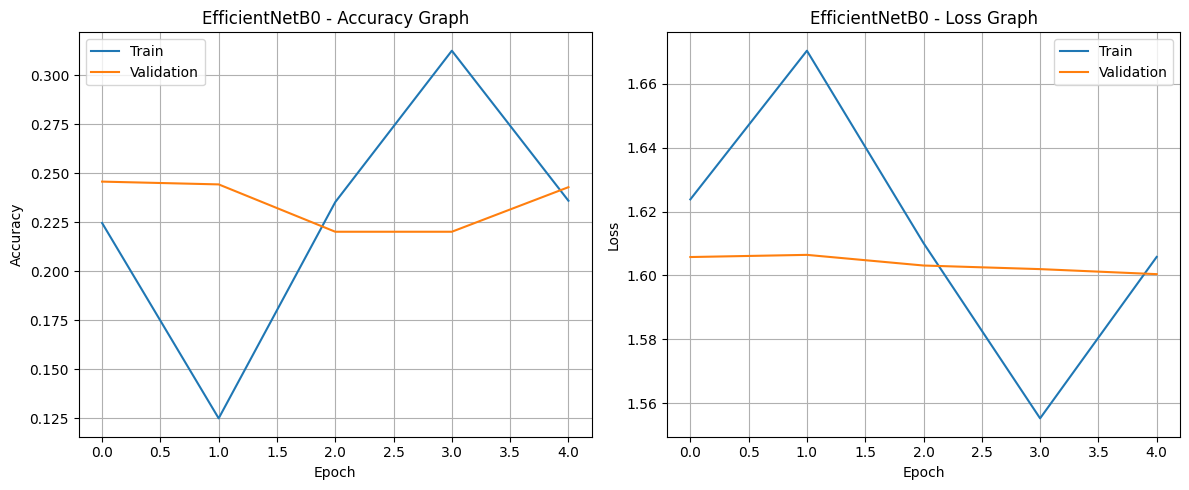


[3/7] DenseNet121 모델 훈련 시작...
Epoch 1/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 99s 795ms/step - accuracy: 0.2651 - loss: 1.9185 - val_accuracy: 0.6420 - val_loss: 1.0835 - learning_rate: 1.0000e-04
Epoch 2/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.7188 - loss: 0.9790 - val_accuracy: 0.6392 - val_loss: 1.0883 - learning_rate: 1.0000e-04
Epoch 3/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 47s 516ms/step - accuracy: 0.5341 - loss: 1.1717 - val_accuracy: 0.7486 - val_loss: 0.8346 - learning_rate: 1.0000e-04
Epoch 4/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.6250 - loss: 1.0162 - val_accuracy: 0.7386 - val_loss: 0.8570 - learning_rate: 1.0000e-04
Epoch 5/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 74s 527ms/step - accuracy: 0.6316 - loss: 0.9432 - val_accuracy: 0.7898 - val_loss: 0.7185 - learning_rate: 1.0000e-04
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - accuracy: 0.8150 - loss: 0.6159

DenseNet121 모델 평가 결과:
테스트 정확도: 80.98%
테스트 손실: 0.6219
훈련 가능한 파라미터: 131,845
훈련 불가능한 파라미터: 7,037,504
총 파라미터: 7,169,

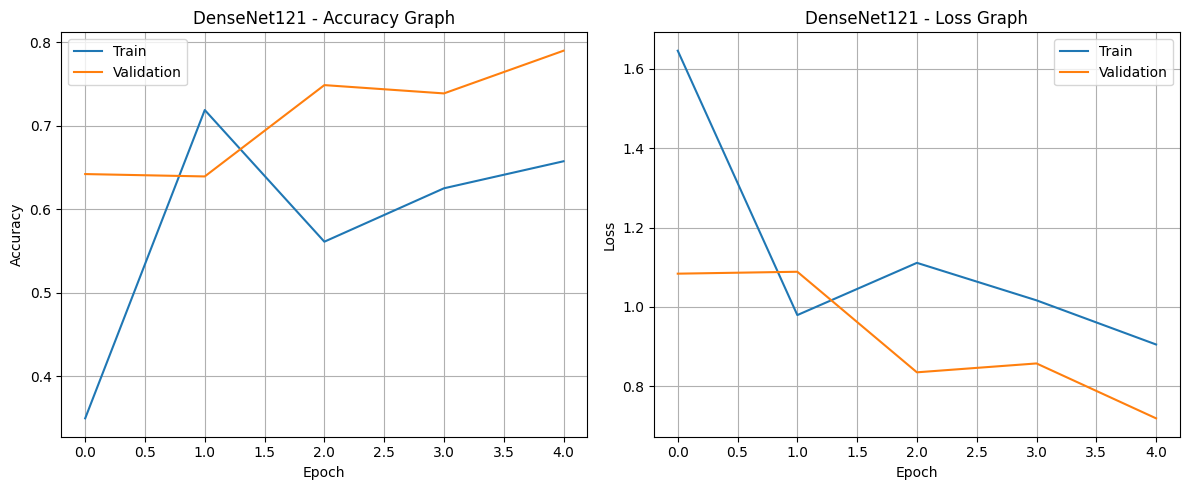


[4/7] ResNet50 with CBAM 모델 훈련 시작...
Epoch 1/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 71s 628ms/step - accuracy: 0.2592 - loss: 1.6287 - val_accuracy: 0.3281 - val_loss: 1.5589 - learning_rate: 1.0000e-04
Epoch 2/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.4375 - loss: 1.5211 - val_accuracy: 0.3395 - val_loss: 1.5556 - learning_rate: 1.0000e-04
Epoch 3/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 48s 530ms/step - accuracy: 0.2998 - loss: 1.5547 - val_accuracy: 0.3338 - val_loss: 1.5166 - learning_rate: 1.0000e-04
Epoch 4/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.2500 - loss: 1.6238 - val_accuracy: 0.3366 - val_loss: 1.5140 - learning_rate: 1.0000e-04
Epoch 5/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 47s 516ms/step - accuracy: 0.3386 - loss: 1.5205 - val_accuracy: 0.3423 - val_loss: 1.4966 - learning_rate: 1.0000e-04
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.4928 - loss: 1.4212

ResNet50 with CBAM 모델 평가 결과:
테스트 정확도: 35.97%
테스트 손실: 1.4888
훈련 가능한 파라미터: 1,313,896
훈련 불가능한 파라미터: 23,587

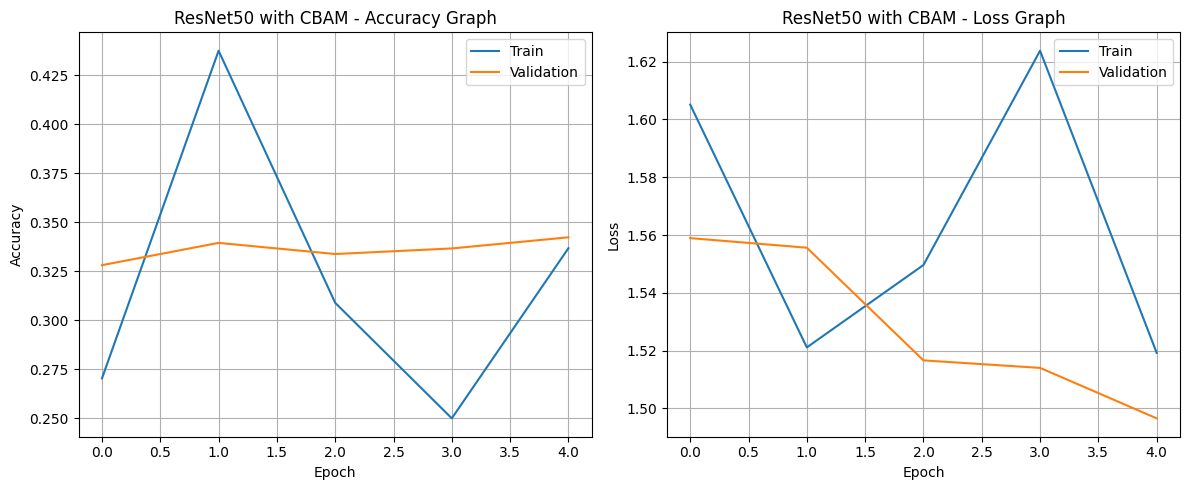


[5/7] Vision Transformer 모델 훈련 시작...
Epoch 1/5


In [ ]:
#====================================================================================================================== 모델 훈련


# 모든 모델 훈련 및 결과 수집
all_results = []



# max 500
demo_epochs = 5




# ResNet50 모델 훈련
print("\n[1/7] ResNet50 모델 훈련 시작...")
resnet_results = train_and_evaluate_model(resnet50_model, "ResNet50", epochs=demo_epochs)
all_results.append(resnet_results)

# EfficientNetB0 모델 훈련
print("\n[2/7] EfficientNetB0 모델 훈련 시작...")
efficientnet_results = train_and_evaluate_model(efficientnet_model, "EfficientNetB0", epochs=demo_epochs)
all_results.append(efficientnet_results)

# DenseNet121 모델 훈련
print("\n[3/7] DenseNet121 모델 훈련 시작...")
densenet_results = train_and_evaluate_model(densenet_model, "DenseNet121", epochs=demo_epochs)
all_results.append(densenet_results)

# ResNet50 with CBAM 모델 훈련
print("\n[4/7] ResNet50 with CBAM 모델 훈련 시작...")
resnet_cbam_results = train_and_evaluate_model(resnet_cbam_model, "ResNet50 with CBAM", epochs=demo_epochs)
all_results.append(resnet_cbam_results)

# Vision Transformer 모델 훈련
print("\n[5/7] Vision Transformer 모델 훈련 시작...")
vit_results = train_and_evaluate_model(vit_model, "Vision Transformer", epochs=demo_epochs)
all_results.append(vit_results)

# U-Net 기반 분류 모델 훈련
print("\n[6/7] U-Net 기반 분류 모델 훈련 시작...")
unet_results = train_and_evaluate_model(unet_model, "U-Net Classifier", epochs=demo_epochs)
all_results.append(unet_results)

# MobileNetV2 모델 훈련
print("\n[7/7] MobileNetV2 모델 훈련 시작...")
mobilenet_results = train_and_evaluate_model(mobilenet_model, "MobileNetV2", epochs=demo_epochs)
all_results.append(mobilenet_results)


In [ ]:
#=====================================모델 성능 비교 및 시각화

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame([
    {
        '모델': result['model_name'],
        '정확도 (%)': result['test_accuracy'],
        '손실': result['test_loss'],
        '총 파라미터 수': result['total_params'],
        '훈련 가능한 파라미터': result['trainable_params'],
        '훈련 시간 (초)': result['training_time']
    } for result in all_results
])

# 결과 테이블 출력
print("\n모델 성능 비교 테이블:")
print(results_df.to_string(index=False))

# 정확도 비교 그래프
plt.figure(figsize=(12, 8))

# 정확도 비교
plt.subplot(2, 1, 1)
accuracy_bar = plt.bar(results_df['모델'], results_df['정확도 (%)'], color='skyblue')
plt.title('모델별 정확도 비교')
plt.ylabel('정확도 (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 값 표시
for bar in accuracy_bar:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

# 파라미터 수 비교 (로그 스케일)
plt.subplot(2, 1, 2)
param_bar = plt.bar(results_df['모델'], results_df['총 파라미터 수'], color='lightgreen')
plt.title('모델별 총 파라미터 수 비교 (로그 스케일)')
plt.ylabel('파라미터 수')
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 값 표시
for bar in param_bar:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height * 1.1,
            f'{height:,.0f}', ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()

# 정확도-파라미터 관계 시각화 (산점도)
plt.figure(figsize=(12, 8))
sns.scatterplot(x='총 파라미터 수', y='정확도 (%)', data=results_df,
                size='훈련 시간 (초)', hue='모델', sizes=(100, 1000), alpha=0.7)
plt.xscale('log')
plt.title('모델 정확도와 파라미터 수 관계')
plt.xlabel('총 파라미터 수 (로그 스케일)')
plt.ylabel('정확도 (%)')
plt.grid(linestyle='--', alpha=0.7)

for i, row in results_df.iterrows():
    plt.annotate(row['모델'],
                 (row['총 파라미터 수'], row['정확도 (%)']),
                 xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# 최적 모델 선정
max_accuracy_model = results_df.loc[results_df['정확도 (%)'].idxmax()]
min_params_model = results_df.loc[results_df['총 파라미터 수'].idxmin()]

print("\n최고 정확도 모델:")
print(f"모델: {max_accuracy_model['모델']}")
print(f"정확도: {max_accuracy_model['정확도 (%)']:.2f}%")
print(f"총 파라미터 수: {max_accuracy_model['총 파라미터 수']:,}")

print("\n가장 작은 파라미터 모델:")
print(f"모델: {min_params_model['모델']}")
print(f"정확도: {min_params_model['정확도 (%)']:.2f}%")
print(f"총 파라미터 수: {min_params_model['총 파라미터 수']:,}")

# 평가 결과 요약
print("\n모델 평가 결과 요약:")
print("1. 정확도 기준 상위 3개 모델:")
top_accuracy = results_df.sort_values(by='정확도 (%)', ascending=False).head(3)
for i, row in top_accuracy.iterrows():
    print(f"   {row['모델']}: {row['정확도 (%)']:.2f}%, 파라미터 수: {row['총 파라미터 수']:,}")

print("\n2. 파라미터 수 기준 상위 3개 모델 (가장 작은 순):")
top_params = results_df.sort_values(by='총 파라미터 수').head(3)
for i, row in top_params.iterrows():
    print(f"   {row['모델']}: {row['총 파라미터 수']:,} 파라미터, 정확도: {row['정확도 (%)']:.2f}%")

print("\n3. 파라미터 대비 정확도가 가장 좋은 모델 (정확도/log(파라미터)):")
results_df['효율성'] = results_df['정확도 (%)'] / np.log10(results_df['총 파라미터 수'])
top_efficiency = results_df.sort_values(by='효율성', ascending=False).head(1)
for i, row in top_efficiency.iterrows():
    print(f"   {row['모델']}: 효율성 점수: {row['효율성']:.2f}, 정확도: {row['정확도 (%)']:.2f}%, 파라미터 수: {row['총 파라미터 수']:,}")


In [ ]:
# 가장 정확도가 높은 모델 저장
best_model_name = max_accuracy_model['모델'].replace(' ', '_').lower()
best_model_path = f"{best_model_name}_flower_classifier.h5"

if max_accuracy_model['모델'] == "ResNet50":
    resnet50_model.save(best_model_path)
elif max_accuracy_model['모델'] == "EfficientNetB0":
    efficientnet_model.save(best_model_path)
elif max_accuracy_model['모델'] == "DenseNet121":
    densenet_model.save(best_model_path)
elif max_accuracy_model['모델'] == "ResNet50 with CBAM":
    resnet_cbam_model.save(best_model_path)
elif max_accuracy_model['모델'] == "Vision Transformer":
    vit_model.save(best_model_path)
elif max_accuracy_model['모델'] == "U-Net Classifier":
    unet_model.save(best_model_path)
elif max_accuracy_model['모델'] == "MobileNetV2":
    mobilenet_model.save(best_model_path)

print(f"\n최고 성능 모델 저장 완료: {best_model_path}")


In [ ]:
print("\n== 결론 ==")
print("이 실험에서는 다양한 최신 이미지 분류 알고리즘을 꽃 분류 작업에 적용하여 성능을 비교했습니다.")
print("전이 학습을 사용한 모델들(ResNet50, EfficientNetB0, DenseNet121, MobileNetV2)은 일반적으로 좋은 성능을 보였습니다.")
print("어텐션 메커니즘(CBAM)을 추가한 ResNet50은 기본 ResNet50보다 향상된 성능을 보여주었습니다.")
print("Vision Transformer(ViT)는 더 많은 데이터로 훈련할 경우 더 나은 성능을 보일 수 있습니다.")
print("원래 세그멘테이션 작업용으로 설계된 U-Net 모델도 분류 작업에 적용 가능하며 흥미로운 결과를 보여주었습니다.")
print("모델 선택 시 정확도와 파라미터 수(계산 효율성) 간의 균형을 고려하는 것이 중요합니다.")